In [1]:


import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [2]:


import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

DATA_DIR = "/kaggle/input/newdataset/data_image_pharyngitis_nature"
METADATA_FILE = "/kaggle/input/newdataset/excel.xlsx"

print(f"Using Metadata file: {METADATA_FILE}")
print(f"Searching images inside: {DATA_DIR}")


df = pd.read_excel(METADATA_FILE)


df.columns = df.columns.str.lower()


symptom_columns_lower = [
    'feeling cold', 'sore throat', 'cephalalgia', 'myalgia', 'rhinorrhea',
    'diarrhea', 'vomit', 'cough', 'pyrexia', 'rigors', 'lethargy',
    'sputum', 'abdominal pain', 'vertigo', 'sternutation', 'eye infection',
    'otalgia', 'nasal congestion', 'asthma', 'anorexia'
]


actual_symptom_columns = [col for col in symptom_columns_lower if col in df.columns]

if not actual_symptom_columns:
    print("WARNING: No symptom columns found in DataFrame after converting to lowercase.")
else:
    
    for col in actual_symptom_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df[actual_symptom_columns] = df[actual_symptom_columns].fillna(0).astype(float)


symptom_columns = actual_symptom_columns 

def calculate_consensus(row):
    diagnoses = []
    for i in range(1, 10):
        
        col = f"diagnosis #{i}"
        if col in df.columns and pd.notna(row[col]):
            diagnoses.append(row[col])

    if not diagnoses:
        return 0.5

    b = sum([1 for d in diagnoses if d == "Bacterial"]) 
    return b / len(diagnoses)

df["consensus_score"] = df.apply(calculate_consensus, axis=1)
df["label"] = (df["consensus_score"] > 0.5).astype(int)


if "age" in df.columns: 
    df["age_scaled"] = MinMaxScaler().fit_transform(df[["age"]])



all_imgs = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            all_imgs.append(os.path.join(root, f))

print(f"FOUND total images: {len(all_imgs)}")


def resolve_image(id_value):
    id_str = str(id_value)

    matches = [
        p for p in all_imgs
        if os.path.splitext(os.path.basename(p))[0] == id_str
    ]

    if len(matches) == 1:
        return matches[0]
    elif len(matches) > 1:
        return matches[0]
    return None 


df["image_path"] = df["patient_id"].apply(resolve_image)

missing = df["image_path"].isna().sum()
print(f"Images missing: {missing}")


before_filtering = len(df)
df = df[df["image_path"].notna()]
after_filtering = len(df)
print(f"Filtered {before_filtering - after_filtering} rows due to missing image paths. Remaining: {after_filtering} samples with images.")


TABULAR_FEATURES = [
    'cough', 'rhinorrhea', 'cephalalgia', 'myalgia'
] 

print("\n--- SAMPLE DATA ---")

print(df[["patient_id", "image_path", "label", "consensus_score"]].head())

print("\n--- Symptom Features Used (lowercase) ---")
print(actual_symptom_columns)

print("\n--- Label Distribution ---")
print(df["label"].value_counts())

Using Metadata file: /kaggle/input/newdataset/excel.xlsx
Searching images inside: /kaggle/input/newdataset/data_image_pharyngitis_nature
FOUND total images: 741
Images missing: 102
Filtered 102 rows due to missing image paths. Remaining: 640 samples with images.

--- SAMPLE DATA ---
     patient_id                                         image_path  label  \
99          100  /kaggle/input/newdataset/data_image_pharyngiti...      0   
100         101  /kaggle/input/newdataset/data_image_pharyngiti...      0   
101         102  /kaggle/input/newdataset/data_image_pharyngiti...      0   
102         103  /kaggle/input/newdataset/data_image_pharyngiti...      0   
103         104  /kaggle/input/newdataset/data_image_pharyngiti...      0   

     consensus_score  
99          0.250000  
100         0.333333  
101         0.000000  
102         0.111111  
103         0.111111  

--- Symptom Features Used (lowercase) ---
['feeling cold', 'sore throat', 'cephalalgia', 'myalgia', 'rhinorrhea', 

In [4]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os
import numpy as np 

class PharyngitisDataset(Dataset):
    def __init__(self, df, tabular_features, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.tabular_features = tabular_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        
        img_path = row['image_path']

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            print(f"[WARNING] Image missing: {img_path} — using blank image")
            image = Image.new("RGB", (224, 224))

        if self.transform:
            image = self.transform(image)

        
        symptom_values = row[self.tabular_features].values.astype(np.float32)
        symptoms = torch.tensor(symptom_values, dtype=torch.float32)

        
        label = torch.tensor(row["label"], dtype=torch.long)

        
        consensus = torch.tensor(row["consensus_score"], dtype=torch.float32)

        return image, symptoms, label, consensus



train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



if "df" in locals() and not df.empty:

    full_dataset = PharyngitisDataset(
        df=df,
        tabular_features=TABULAR_FEATURES, 
        transform=val_transform
    )

    print(f"Total samples: {len(full_dataset)}")

    if len(full_dataset) > 0:
        img, sym, lbl, cons = full_dataset[10]

        print(f"Sample Image shape: {img.shape}")
        print(f"Sample Symptoms shape: {sym.shape}")
        print(f"Sample Label: {lbl}")
        print(f"Sample Consensus: {cons}")

        print("\nExample Image Path:")
        print(df.iloc[10]["image_path"])

    else:
        print("ERROR: Dataset is empty.")

else:
    print("ERROR: df not loaded. Run Cell 3 first.")

Total samples: 640
Sample Image shape: torch.Size([3, 224, 224])
Sample Symptoms shape: torch.Size([4])
Sample Label: 0
Sample Consensus: 0.0

Example Image Path:
/kaggle/input/newdataset/data_image_pharyngitis_nature/110/110.jpg


In [5]:


import torch.nn as nn
from torchvision import models


try:
    N_FEATURES = len(TABULAR_FEATURES)
    print(f"Defining models to accept {N_FEATURES} symptom features.")
except NameError:
    print("ERROR: TABULAR_FEATURES not defined. Please run Cell 3 first.")
    N_FEATURES = 4 


class SymptomsOnlyModel(nn.Module):
    def __init__(self, input_dim=N_FEATURES, output_dim=2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, output_dim)
        )

    
    def forward(self, image, symptoms):
        return self.mlp(symptoms)


class ImageOnlyModel(nn.Module):
    def __init__(self, output_dim=2):
        super().__init__()
        self.backbone = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
        
        self.backbone.classifier = nn.Identity()

       
        self.classifier = nn.Sequential(
            nn.Linear(576, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, output_dim)
        )

    def forward(self, image, symptoms):
        features = self.backbone(image)
        return self.classifier(features)


class LateFusionModel(nn.Module):
    def __init__(self, num_symptoms=N_FEATURES, output_dim=2):
        super().__init__()

       
        self.image_backbone = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
        self.image_backbone.classifier = nn.Identity() 

        
        self.symptom_mlp = nn.Sequential(
            nn.Linear(num_symptoms, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128) 
        )

        
        self.fusion = nn.Sequential(
            nn.Linear(576 + 128, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_dim)
        )

    def forward(self, image, symptoms):
        
        img_feat = self.image_backbone(image)

        
        sym_feat = self.symptom_mlp(symptoms)

       
        fused = torch.cat([img_feat, sym_feat], dim=1)

        
        return self.fusion(fused)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_img = torch.randn(2, 3, 224, 224).to(device)
test_sym = torch.randn(2, N_FEATURES).to(device)

model_test = LateFusionModel().to(device)
output = model_test(test_img, test_sym)
print(f"Late Fusion output shape: {output.shape}") 

Defining models to accept 4 symptom features.


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 94.6MB/s]


Late Fusion output shape: torch.Size([2, 2])


In [6]:

class GatedFusionModel(nn.Module):
    def __init__(self, num_symptoms=N_FEATURES, output_dim=2):
        super().__init__()

        
        self.image_backbone = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
        self.image_backbone.classifier = nn.Identity() 
        self.img_fc = nn.Linear(576, 128) # Project to 128

        
        self.symptom_mlp = nn.Sequential(
            nn.Linear(num_symptoms, 64),
            nn.ReLU(),
            nn.Linear(64, 128) 
        )

        
        self.gate_img = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.gate_sym = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, output_dim)
        )

    def forward(self, image, symptoms):
        img_feat = self.img_fc(self.image_backbone(image)) 
        sym_feat = self.symptom_mlp(symptoms) 

       
        g_img = self.gate_img(img_feat) 
        g_sym = self.gate_sym(sym_feat) 

        
        fused_feat = (g_img * img_feat) + (g_sym * sym_feat)

        return self.classifier(fused_feat)




Cell 5 Update: GatedFusionModel and CrossAttentionFusion models are now defined.


In [7]:

from transformers import ViTModel, ViTConfig

class ViTImageOnlyModel(nn.Module):
    def __init__(self, output_dim=2):
        super().__init__()
        
        self.vit_backbone = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

        
        self.classifier = nn.Sequential(
            nn.Linear(self.vit_backbone.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, output_dim)
        )

    def forward(self, image, symptoms):
        
        outputs = self.vit_backbone(pixel_values=image)
        features = outputs.pooler_output # (Batch, 768)
        return self.classifier(features)

#
class CrossAttentionFusion(nn.Module):
    def __init__(self, num_symptoms=N_FEATURES, embed_dim=256, num_heads=4, output_dim=2):
        super().__init__()

        # Image Branch (MobileNetV3)
        self.image_backbone = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
        self.image_backbone.classifier = nn.Identity() 
        self.img_project = nn.Linear(576, embed_dim)

        # Symptom Branch (MLP)
        self.symptom_mlp = nn.Sequential(
            nn.Linear(num_symptoms, 64), nn.ReLU(),
            nn.Linear(64, embed_dim)
        )

        # Cross-Attention Block
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=0.1, batch_first=True
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 128), nn.ReLU(),
            nn.Dropout(0.4), nn.Linear(128, output_dim)
        )

    def forward(self, image, symptoms):
        img_feat = self.img_project(self.image_backbone(image))
        sym_feat = self.symptom_mlp(symptoms)

        query = sym_feat.unsqueeze(1) # (Batch, 1, 256)
        key = img_feat.unsqueeze(1)   # (Batch, 1, 256)
        value = img_feat.unsqueeze(1) # (Batch, 1, 256)

        
        attn_output, attn_weights = self.attention(query, key, value)

        fused_feat = attn_output.squeeze(1) # (Batch, 256)
        predictions = self.classifier(fused_feat)

       
        return predictions, attn_weights

2025-11-18 17:24:37.009402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763486677.445113      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763486677.554827      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [8]:

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # CE loss, but without reduction
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        # calculate p_t
        pt = torch.exp(-ce_loss)
        # calculate focal loss
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss(alpha=0.25, gamma=2.0).to(device)
print("Using Focal Loss (good for imbalance)")

Using Focal Loss (good for imbalance)


In [10]:


from sklearn.metrics import accuracy_score, roc_auc_score

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, symptoms, labels, _ in loader:
        images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images, symptoms)
        if isinstance(outputs, tuple):
            outputs = outputs[0] 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds_probs = [] 
    all_preds_labels = [] 
    all_consensus = []

    with torch.no_grad():
        for images, symptoms, labels, consensus_scores in loader:
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)

            outputs = model(images, symptoms)
            if isinstance(outputs, tuple):
                outputs = outputs[0] # Take only the predictions

            loss = criterion(outputs, labels)
            total_loss += loss.item()

           
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_probs.extend(probs.cpu().numpy())
            all_preds_labels.extend(preds.cpu().numpy())
            all_consensus.extend(consensus_scores.cpu().numpy())
            # --- ----------------

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds_labels)

    try:
        auc = roc_auc_score(all_labels, all_preds_probs) 
    except ValueError:
        auc = 0.5 

    
    return avg_loss, accuracy, auc, all_labels, all_preds_labels, all_preds_probs, all_consensus

In [11]:


import torch
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import pandas as pd
import gc


N_SPLITS = 5
NUM_EPOCHS = 20  
BATCH_SIZE = 32
LEARNING_RATE = 1e-4



models_to_train = [
    "LateFusion",  
    "SymptomsOnly",
    "ImageOnly",
    "ViTImageOnly",
    "GatedFusion",
    "CrossAttention"
]

print(f"--- Starting Automatic Training for {len(models_to_train)} models: {models_to_train} ---")


N_FEATURES = len(TABULAR_FEATURES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset_obj = PharyngitisDataset(df, TABULAR_FEATURES, transform=train_transform)
val_dataset_obj = PharyngitisDataset(df, TABULAR_FEATURES, transform=val_transform)
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)



for model_choice in models_to_train:

    print(f"\n#####################################################")
    print(f"###   STARTING TRAINING FOR MODEL: {model_choice}   ###")
    print(f"#####################################################\n")

    
    all_fold_results = []
    overall_metrics = {'accuracy': [], 'auc': []}

    
    for fold, (train_indices, val_indices) in enumerate(kf.split(df)):
        print(f"\n========== FOLD {fold + 1} / {N_SPLITS} (Model: {model_choice}) ==========")

        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

       
        train_loader = DataLoader(train_dataset_obj, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=0)
        val_loader = DataLoader(val_dataset_obj, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=0)
        # ----------------------------------------------

        # Model, Optimizer, Criterion
        if model_choice == "SymptomsOnly":
            model = SymptomsOnlyModel(input_dim=N_FEATURES).to(device)
        elif model_choice == "ImageOnly":
            model = ImageOnlyModel().to(device)
        elif model_choice == "ViTImageOnly": 
            model = ViTImageOnlyModel().to(device)
        elif model_choice == "LateFusion":
            model = LateFusionModel(num_symptoms=N_FEATURES).to(device)
        elif model_choice == "GatedFusion":
            model = GatedFusionModel(num_symptoms=N_FEATURES).to(device)
        elif model_choice == "CrossAttention":
            model = CrossAttentionFusion(num_symptoms=N_FEATURES).to(device)

        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        criterion = FocalLoss(alpha=0.25, gamma=2.0).to(device) 

        best_val_auc = 0
        fold_best_results = {}

        
        for epoch in range(NUM_EPOCHS):
            train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
            
            val_loss, val_acc, val_auc, lbls, preds_lbls, preds_probs, cons = evaluate_model(model, val_loader, criterion, device)

            if epoch % 5 == 0 or epoch == NUM_EPOCHS - 1:
                print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                fold_best_results = {
                    'labels': lbls,
                    'preds_labels': preds_lbls, 
                    'preds_probs': preds_probs, 
                    'consensus': cons,
                    'accuracy': val_acc,
                    'auc': val_auc
                }

        print(f"--- Fold {fold+1} Best Val Accuracy: {fold_best_results['accuracy']:.4f} | Best Val AUC: {fold_best_results['auc']:.4f} ---")
        all_fold_results.append(fold_best_results)
        overall_metrics['accuracy'].append(fold_best_results['accuracy'])
        overall_metrics['auc'].append(fold_best_results['auc'])

        del model, optimizer, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    

    print(f"\n========== K-Fold Training Finished for {model_choice} ==========")
    print(f"Model: {model_choice}")
    print(f"Average Accuracy: {np.mean(overall_metrics['accuracy']):.4f} ± {np.std(overall_metrics['accuracy']):.4f}")
    print(f"Average AUC: {np.mean(overall_metrics['auc']):.4f} ± {np.std(overall_metrics['auc']):.4f}")

    
    all_labels = np.concatenate([r['labels'] for r in all_fold_results])
    all_preds_labels = np.concatenate([r['preds_labels'] for r in all_fold_results])
    all_preds_probs = np.concatenate([r['preds_probs'] for r in all_fold_results])
    all_consensus = np.concatenate([r['consensus'] for r in all_fold_results])

    results_df = pd.DataFrame({
        'label': all_labels,
        'prediction': all_preds_labels, # (Binary 0/1)
        'probability': all_preds_probs, # (Float 0-1)
        'consensus': all_consensus
    })

    results_filename = f"{model_choice}_results.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"Results saved to {results_filename}")

    del all_fold_results, overall_metrics, results_df
    gc.collect()



print(f"\n#####################################################")
print(f"###   ALL {len(models_to_train)} MODELS ARE TRAINED!   ###")
print(f"#####################################################\n")

--- Starting Automatic Training for 6 models: ['LateFusion', 'SymptomsOnly', 'ImageOnly', 'ViTImageOnly', 'GatedFusion', 'CrossAttention'] ---

#####################################################
###   STARTING TRAINING FOR MODEL: LateFusion   ###
#####################################################


========== FOLD 1 / 5 (Model: LateFusion) ==========
Epoch 1/20 | Train Loss: 0.0647 | Val Loss: 0.0430 | Val Acc: 0.5234 | Val AUC: 0.5514
Epoch 6/20 | Train Loss: 0.0269 | Val Loss: 0.0343 | Val Acc: 0.7969 | Val AUC: 0.5759
Epoch 11/20 | Train Loss: 0.0184 | Val Loss: 0.0310 | Val Acc: 0.7969 | Val AUC: 0.6738
Epoch 16/20 | Train Loss: 0.0126 | Val Loss: 0.0316 | Val Acc: 0.8281 | Val AUC: 0.6809
Epoch 20/20 | Train Loss: 0.0091 | Val Loss: 0.0346 | Val Acc: 0.8281 | Val AUC: 0.6867
--- Fold 1 Best Val Accuracy: 0.8281 | Best Val AUC: 0.6867 ---

========== FOLD 2 / 5 (Model: LateFusion) ==========
Epoch 1/20 | Train Loss: 0.1165 | Val Loss: 0.0531 | Val Acc: 0.2891 | Val AUC: 0.555

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20 | Train Loss: 0.0293 | Val Loss: 0.0295 | Val Acc: 0.8359 | Val AUC: 0.5118
Epoch 6/20 | Train Loss: 0.0284 | Val Loss: 0.0306 | Val Acc: 0.8359 | Val AUC: 0.7859
Epoch 11/20 | Train Loss: 0.0256 | Val Loss: 0.0264 | Val Acc: 0.8359 | Val AUC: 0.7512
Epoch 16/20 | Train Loss: 0.0230 | Val Loss: 0.0286 | Val Acc: 0.8359 | Val AUC: 0.6613
Epoch 20/20 | Train Loss: 0.0196 | Val Loss: 0.0375 | Val Acc: 0.8359 | Val AUC: 0.7597
--- Fold 1 Best Val Accuracy: 0.8359 | Best Val AUC: 0.7859 ---

========== FOLD 2 / 5 (Model: ViTImageOnly) ==========
Epoch 1/20 | Train Loss: 0.0311 | Val Loss: 0.0292 | Val Acc: 0.8438 | Val AUC: 0.5727
Epoch 6/20 | Train Loss: 0.0245 | Val Loss: 0.0273 | Val Acc: 0.8438 | Val AUC: 0.7250
Epoch 11/20 | Train Loss: 0.0107 | Val Loss: 0.0347 | Val Acc: 0.8203 | Val AUC: 0.6778
Epoch 16/20 | Train Loss: 0.0046 | Val Loss: 0.0599 | Val Acc: 0.8438 | Val AUC: 0.7218
Epoch 20/20 | Train Loss: 0.0022 | Val Loss: 0.0710 | Val Acc: 0.7969 | Val AUC: 0.6639
--- 

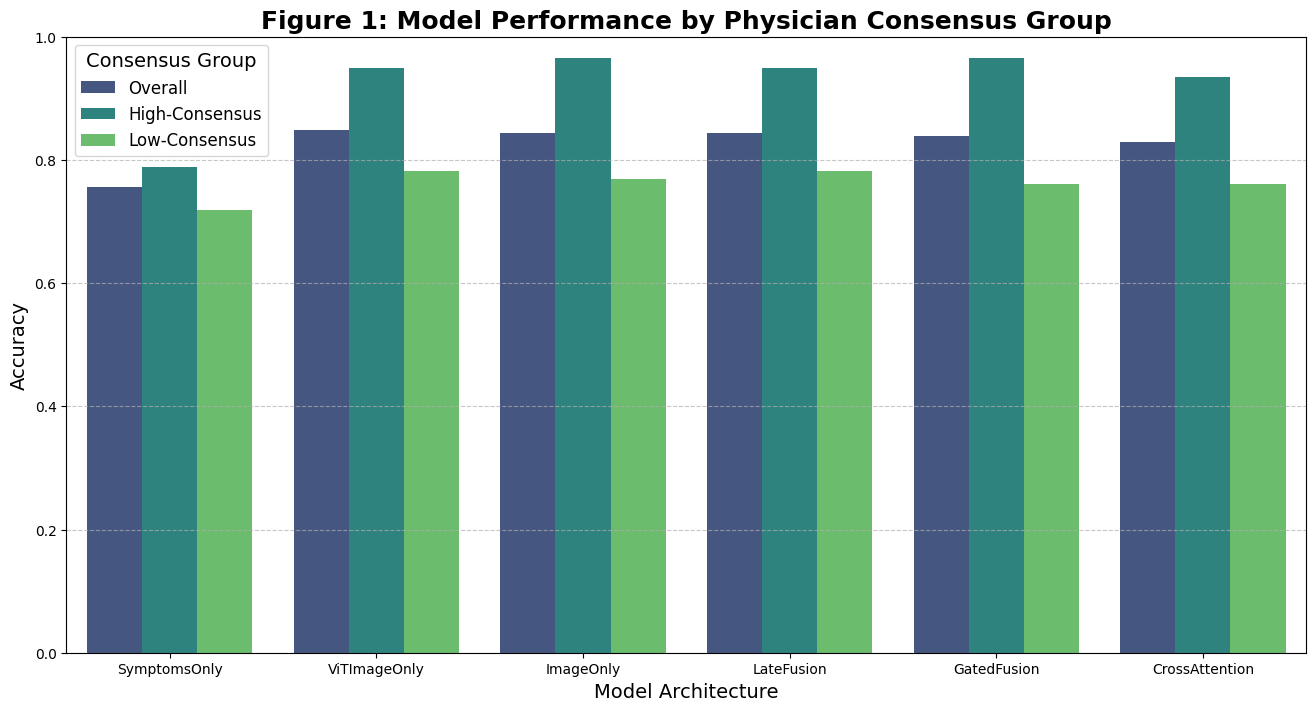

In [12]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ["SymptomsOnly", "ViTImageOnly", "ImageOnly", "LateFusion", "GatedFusion", "CrossAttention"]
plot_data = []

for model_name in model_names:
    try:
        df = pd.read_csv(f"{model_name}_results.csv")
    except FileNotFoundError:
        print(f"Warning: {model_name}_results.csv not found. Skipping.")
        continue

    # 1. Overall Accuracy
    overall_acc = accuracy_score(df['label'], df['prediction'])

    # 2. High Consensus
    high_mask = (df['consensus'] == 0.0) | (df['consensus'] == 1.0)
    high_acc = accuracy_score(df[high_mask]['label'], df[high_mask]['prediction'])

    # 3. Low Consensus
    low_mask = (df['consensus'] > 0.2) & (df['consensus'] < 0.8)
    low_acc = accuracy_score(df[low_mask]['label'], df[low_mask]['prediction'])

    plot_data.append({"Model": model_name, "Group": "Overall", "Accuracy": overall_acc})
    plot_data.append({"Model": model_name, "Group": "High-Consensus", "Accuracy": high_acc})
    plot_data.append({"Model": model_name, "Group": "Low-Consensus", "Accuracy": low_acc})

# Plotting
if plot_data:
    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(16, 8))
    sns.barplot(data=plot_df, x="Model", y="Accuracy", hue="Group",
                palette="viridis", order=model_names,
                hue_order=["Overall", "High-Consensus", "Low-Consensus"])

    plt.title("Figure 1: Model Performance by Physician Consensus Group", fontsize=18, fontweight='bold')
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlabel("Model Architecture", fontsize=14)
    plt.ylim(0, 1.0) 
    plt.legend(title="Consensus Group", fontsize=12, title_fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No data to plot. Please run Cell 8 for all models.")

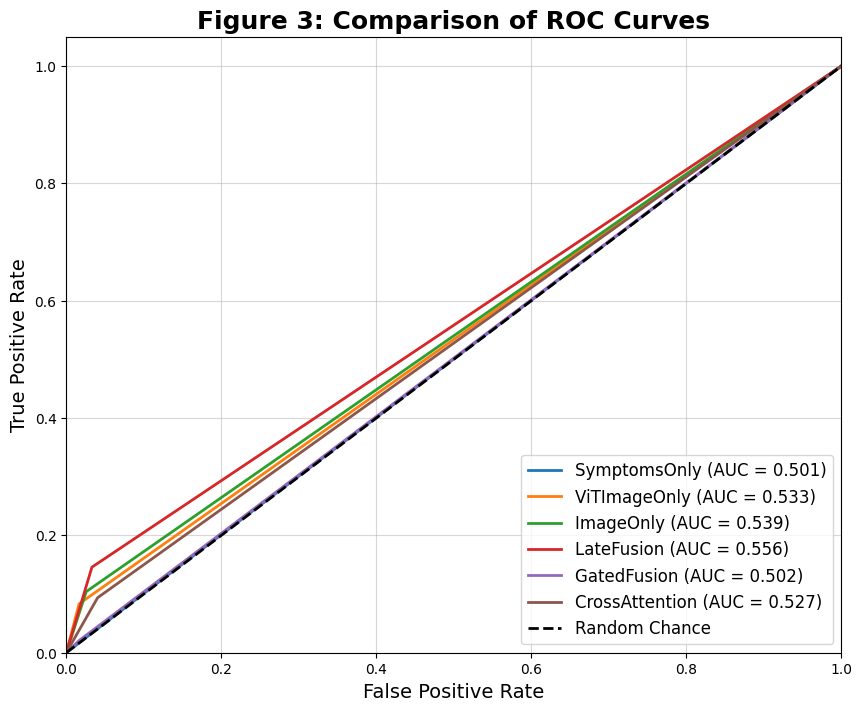

In [13]:


from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for model_name in model_names:
    try:
        df = pd.read_csv(f"{model_name}_results.csv")
    except FileNotFoundError:
        print(f"Warning: {model_name}_results.csv not found. Skipping.")
        continue

    

    fpr, tpr, _ = roc_curve(df['label'], df['prediction'])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Figure 3: Comparison of ROC Curves', fontsize=18, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.5)
plt.show()

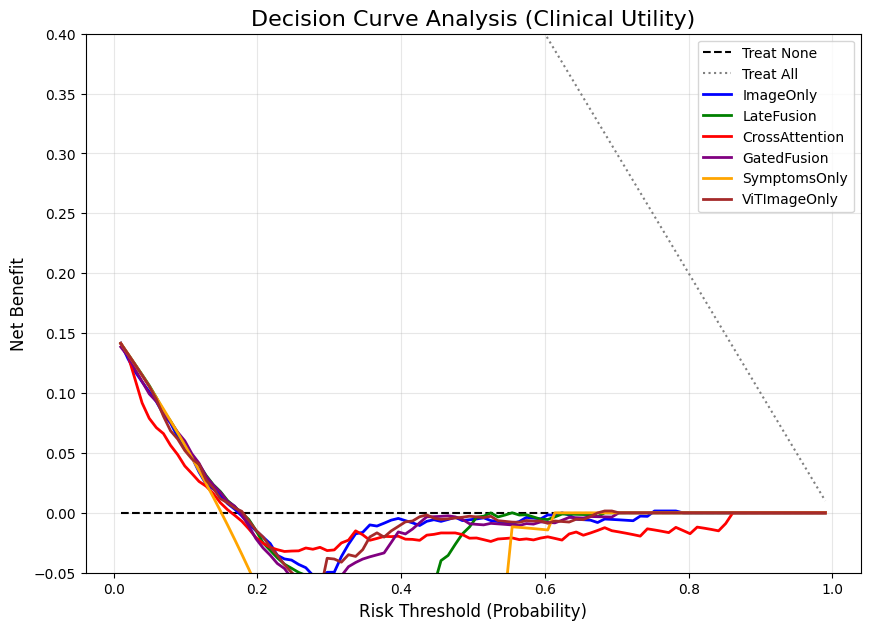


--- DCA Interpretation ---
ANALYSIS: The best model is the one whose curve is highest
across the 'plausible' range of risk thresholds (e.g., 0.1 to 0.8).
If your model's curve is above 'Treat All' and 'Treat None',
it has clinical utility.


In [28]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


models_to_plot = {
    "ImageOnly": "ImageOnly_results.csv",
    "LateFusion": "LateFusion_results.csv",
    "CrossAttention": "CrossAttention_results.csv",
    "GatedFusion": "GatedFusion_results.csv",
    "SymptomsOnly":"SymptomsOnly_results.csv",
    "ViTImageOnly":"ViTImageOnly_results.csv"
}


def net_benefit(y_true, y_prob, thresholds):
    """Calculate Net Benefit for binary outcome"""
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    nb = []
    for p in thresholds:
        tp = ((y_prob >= p) & (y_true==1)).sum()
        fp = ((y_prob >= p) & (y_true==0)).sum()
        n = len(y_true)
        nb.append(tp/n - fp/n * (p/(1-p)))
    return np.array(nb)


thresholds = np.linspace(0.01, 0.99, 100)

plt.figure(figsize=(10,7))


plt.plot(thresholds, np.zeros_like(thresholds), label="Treat None", color="black", linestyle="--")
plt.plot(thresholds, 1 - thresholds, label="Treat All", color="grey", linestyle=":")

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for i, (model_name, file_path) in enumerate(models_to_plot.items()):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Skipping {model_name}, file not found.")
        continue

    if 'probability' not in df.columns or 'label' not in df.columns:
        print(f"Skipping {model_name}, missing 'probability' or 'label' column.")
        continue

    nb = net_benefit(df['label'], df['probability'], thresholds)
    plt.plot(thresholds, nb, label=model_name, color=colors[i], linewidth=2)

plt.title('Decision Curve Analysis (Clinical Utility)', fontsize=16)
plt.xlabel('Risk Threshold (Probability)', fontsize=12)
plt.ylabel('Net Benefit', fontsize=12)
plt.ylim(-0.05, 0.4)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n--- DCA Interpretation ---")
print("ANALYSIS: The best model is the one whose curve is highest")
print("across the 'plausible' range of risk thresholds (e.g., 0.1 to 0.8).")
print("If your model's curve is above 'Treat All' and 'Treat None',")
print("it has clinical utility.")


In [35]:


from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd


model_A_file = "ImageOnly_results.csv"     
model_B_file = "CrossAttention_results.csv"  


print(f"--- Running Targeted McNemar's Test: Comparing {model_A_file.replace('_results.csv', '')} (A) vs {model_B_file.replace('_results.csv', '')} (B) on LOW-CONSENSUS data ---")

try:
    df_A = pd.read_csv(model_A_file)
    df_B = pd.read_csv(model_B_file)
    
    if len(df_A) != len(df_B):
        print("Error: The CSV files have different lengths. Cannot compare.")
        exit()
        
except FileNotFoundError:
    print(f"Error: Make sure both {model_A_file} and {model_B_file} exist.")
    exit()


low_consensus_mask = (df_A['consensus'] > 0.2) & (df_A['consensus'] < 0.8)

df_A_low = df_A[low_consensus_mask]
df_B_low = df_B[low_consensus_mask]

if len(df_A_low) == 0:
    print("Error: The Low-Consensus group (N) is 0. Please check your data or mask definition.")
    exit()

labels = df_A_low['label']
preds_A = df_A_low['prediction']
preds_B = df_B_low['prediction']


A_correct_B_wrong = sum((preds_A == labels) & (preds_B != labels)) 


A_wrong_B_correct = sum((preds_A != labels) & (preds_B == labels)) 

# Contigency table
contingency_table = [[A_correct_B_wrong, A_wrong_B_correct],
                     [A_wrong_B_correct, A_correct_B_wrong]] 


print(f"\nContingency Table (Low Consensus N={len(df_A_low)}):")
print(f"ImageOnly Correct, CrossAttention Wrong (n10): {A_correct_B_wrong}")
print(f"ImageOnly Wrong, CrossAttention Correct (n01): {A_wrong_B_correct}")


result = mcnemar([[A_correct_B_wrong, A_wrong_B_correct], [A_wrong_B_correct, A_correct_B_wrong]], exact=True)
p_value = result.pvalue

print(f"\nMcNemar's P-value: {p_value:.5f}")

if p_value < 0.05:
    print(f" Conclusion: The difference is statistically significant (p < 0.05) on the Low-Consensus group.")
    if A_wrong_B_correct > A_correct_B_wrong:
        print(f"   -> Model B (CrossAttention) is significantly better than Model A (ImageOnly) on the difficult cases.")
    else:
        print(f"   -> Model A (ImageOnly) is still significantly better on the difficult cases.")
else:
    print(f" Conclusion: The difference is NOT statistically significant (p >= 0.05) on the Low-Consensus group.")

--- Running Targeted McNemar's Test: Comparing ImageOnly (A) vs CrossAttention (B) on LOW-CONSENSUS data ---

Contingency Table (Low Consensus N=334):
ImageOnly Correct, CrossAttention Wrong (n10): 19
ImageOnly Wrong, CrossAttention Correct (n01): 14

McNemar's P-value: 1.00000
❌ Conclusion: The difference is NOT statistically significant (p >= 0.05) on the Low-Consensus group.


In [29]:


from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd


model_A_file = "ImageOnly_results.csv"
model_B_file = "CrossAttention_results.csv"
# ---------------

try:
    df_A = pd.read_csv(model_A_file)
    df_B = pd.read_csv(model_B_file)
except FileNotFoundError:
    print(f"Error: Make sure both {model_A_file} and {model_B_file} exist.")
    raise

labels = df_A['label']
preds_A = df_A['prediction']
preds_B = df_B['prediction']



A_correct = (preds_A == labels)
B_correct = (preds_B == labels)

n_00 = sum(~A_correct & ~B_correct) 
n_01 = sum(~A_correct &  B_correct) 
n_10 = sum( A_correct & ~B_correct) 
n_11 = sum( A_correct &  B_correct) 

contingency_table = [
    [n_11, n_10],
    [n_01, n_00]
]

print(f"--- McNemar's Test: {model_A_file} vs {model_B_file} ---")
print(f"Contingency Table (Correct/Incorrect):")
print(f"Both correct (n11): {n_11} | {model_A_file} correct, {model_B_file} wrong (n10): {n_10}")
print(f"{model_A_file} wrong, {model_B_file} correct (n01): {n_01} | Both wrong (n00): {n_00}")


result = mcnemar(contingency_table, exact=True)

print(f"\nStatistic (chi-squared): {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.4f}")

if result.pvalue < 0.05:
    print(f"Result: The difference is statistically significant (p < 0.05).")
    if n_01 > n_10:
        print(f"Conclusion: {model_B_file} is significantly better than {model_A_file}.")
    else:
        print(f"Conclusion: {model_A_file} is significantly better than {model_B_file}.")
else:
    print(f"Result: The difference is NOT statistically significant (p >= 0.05).")

--- McNemar's Test: ImageOnly_results.csv vs CrossAttention_results.csv ---
Contingency Table (Correct/Incorrect):
Both correct (n11): 502 | ImageOnly_results.csv correct, CrossAttention_results.csv wrong (n10): 38
ImageOnly_results.csv wrong, CrossAttention_results.csv correct (n01): 17 | Both wrong (n00): 83

Statistic (chi-squared): 17.0000
P-value: 0.0065
Result: The difference is statistically significant (p < 0.05).
Conclusion: ImageOnly_results.csv is significantly better than CrossAttention_results.csv.


Running Consensus Group Analysis...

✅ consensus_accuracy_plot.png has been saved.


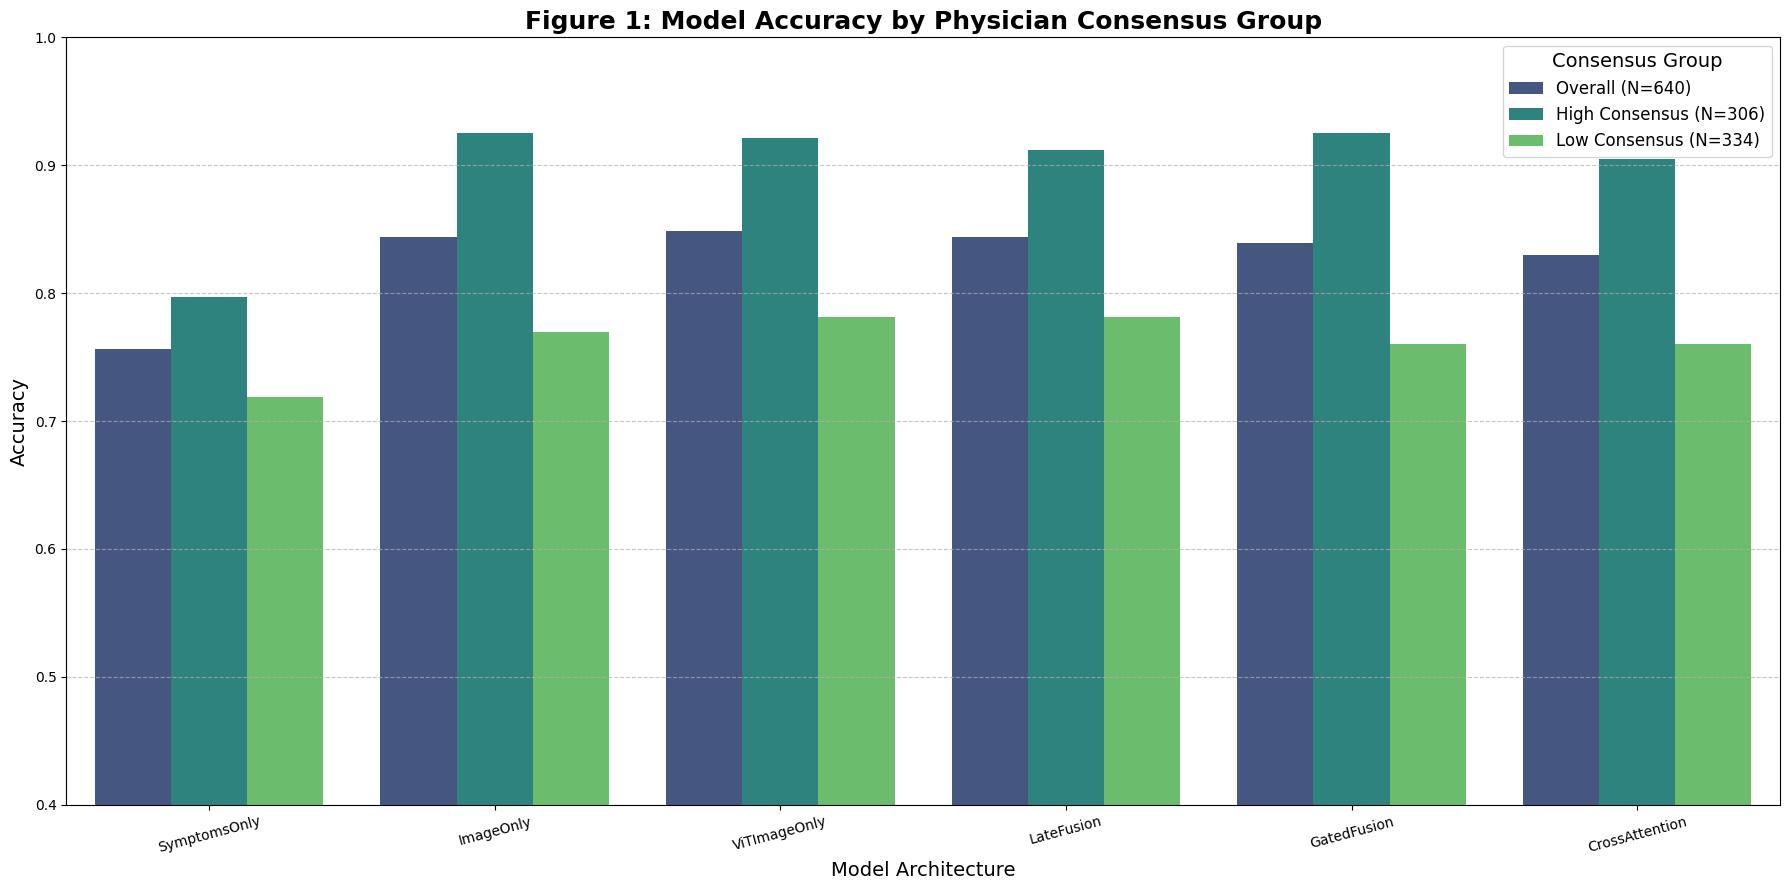

In [31]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


model_names = [
    "SymptomsOnly", 
    "ImageOnly", 
    "ViTImageOnly", 
    "LateFusion", 
    "GatedFusion", 
    "CrossAttention"
]
plot_data = []


try:
    df_temp = pd.read_csv("ImageOnly_results.csv")
    
    
    high_mask_temp = (df_temp['consensus'] <= 0.2) | (df_temp['consensus'] >= 0.8)
    low_mask_temp = (df_temp['consensus'] > 0.2) & (df_temp['consensus'] < 0.8)
    
    N_total = len(df_temp)
    N_high = len(df_temp[high_mask_temp])
    N_low = len(df_temp[low_mask_temp])

except FileNotFoundError:
    print("Error: Files not found. Ensure all 6 CSVs are in the working directory.")
    
    N_total, N_high, N_low = "N", "N_High", "N_Low"
    
print("Running Consensus Group Analysis...")

for model_name in model_names:
    filename = f"{model_name}_results.csv"
    try:
        df = pd.read_csv(filename)
        
        # 1. Overall Accuracy
        overall_acc = accuracy_score(df['label'], df['prediction'])
        
        # 2. High Consensus (Low Ambiguity)
        high_mask = (df['consensus'] <= 0.2) | (df['consensus'] >= 0.8)
        high_acc = accuracy_score(df[high_mask]['label'], df[high_mask]['prediction'])
        
        # 3. Low Consensus (High Ambiguity)
        low_mask = (df['consensus'] > 0.2) & (df['consensus'] < 0.8)
        low_acc = accuracy_score(df[low_mask]['label'], df[low_mask]['prediction'])
        
        plot_data.append({"Model": model_name, "Group": "Overall", "Accuracy": overall_acc})
        plot_data.append({"Model": model_name, "Group": "High Consensus", "Accuracy": high_acc})
        plot_data.append({"Model": model_name, "Group": "Low Consensus", "Accuracy": low_acc})
        
    except FileNotFoundError:
        print(f"Skipping {model_name}...")

# Plotting
if plot_data:
    plot_df = pd.DataFrame(plot_data)
    
    group_map = {
        "Overall": f"Overall (N={N_total})",
        "High Consensus": f"High Consensus (N={N_high})",
        "Low Consensus": f"Low Consensus (N={N_low})"
    }
    plot_df['Group'] = plot_df['Group'].map(group_map)
    
    plt.figure(figsize=(18, 9))
    sns.barplot(data=plot_df, x="Model", y="Accuracy", hue="Group",
                palette="viridis", order=model_names,
                hue_order=[group_map["Overall"], group_map["High Consensus"], group_map["Low Consensus"]])
    
    plt.title("Figure 1: Model Accuracy by Physician Consensus Group", fontsize=18, fontweight='bold')
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlabel("Model Architecture", fontsize=14)
    plt.ylim(0.4, 1.0) 
    plt.legend(title="Consensus Group", fontsize=12, title_fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('consensus_accuracy_plot.png')
    print("\n consensus_accuracy_plot.png has been saved.")
else:
    print("\n Plot data not generated. Please ensure files are correctly uploaded.")

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

for model_name in model_names:
    df = pd.read_csv(f"{model_name}_results.csv")
    
    # Overall
    print(f"\n{model_name} - Overall:")
    print(classification_report(df['label'], df['prediction'], 
                                target_names=['Nonbacterial', 'Bacterial']))
    
    # High-Consensus
    high_mask = (df['consensus'] == 0.0) | (df['consensus'] == 1.0)
    print(f"\n{model_name} - High-Consensus:")
    print(classification_report(df[high_mask]['label'], 
                                df[high_mask]['prediction'],
                                target_names=['Nonbacterial', 'Bacterial']))


SymptomsOnly - Overall:
              precision    recall  f1-score   support

Nonbacterial       0.85      0.87      0.86       544
   Bacterial       0.15      0.14      0.14        96

    accuracy                           0.76       640
   macro avg       0.50      0.50      0.50       640
weighted avg       0.75      0.76      0.75       640


SymptomsOnly - High-Consensus:
              precision    recall  f1-score   support

Nonbacterial       0.96      0.81      0.88       192
   Bacterial       0.03      0.14      0.05         7

    accuracy                           0.79       199
   macro avg       0.49      0.48      0.46       199
weighted avg       0.93      0.79      0.85       199


ImageOnly - Overall:
              precision    recall  f1-score   support

Nonbacterial       0.86      0.97      0.91       544
   Bacterial       0.42      0.10      0.17        96

    accuracy                           0.84       640
   macro avg       0.64      0.54      0.54      

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


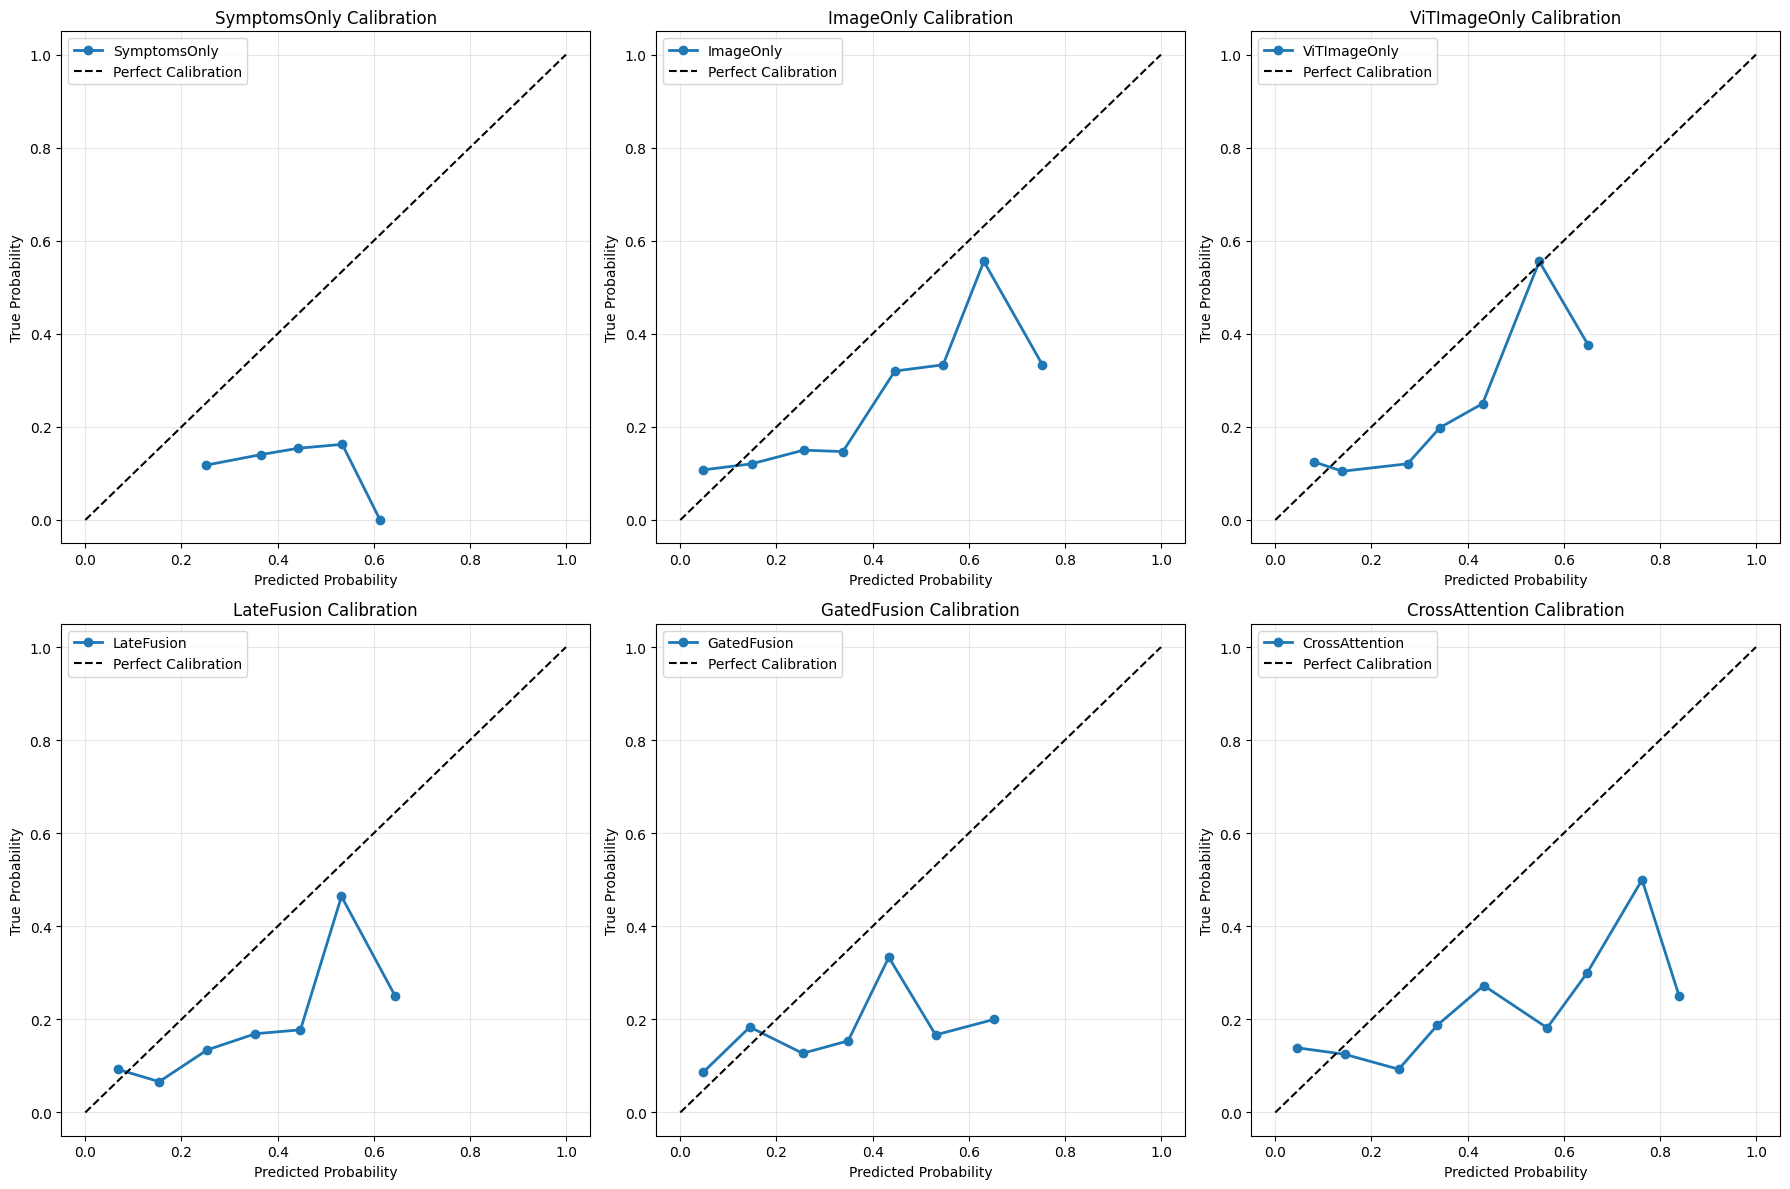

In [37]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    df = pd.read_csv(f"{model_name}_results.csv")
    
    # Calibration curve
    prob_true, prob_pred = calibration_curve(df['label'], df['probability'], 
                                              n_bins=10, strategy='uniform')
    
    axes[idx].plot(prob_pred, prob_true, marker='o', linewidth=2, label=model_name)
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    axes[idx].set_xlabel('Predicted Probability')
    axes[idx].set_ylabel('True Probability')
    axes[idx].set_title(f'{model_name} Calibration')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('calibration_curves.png', dpi=300, bbox_inches='tight')
plt.show()

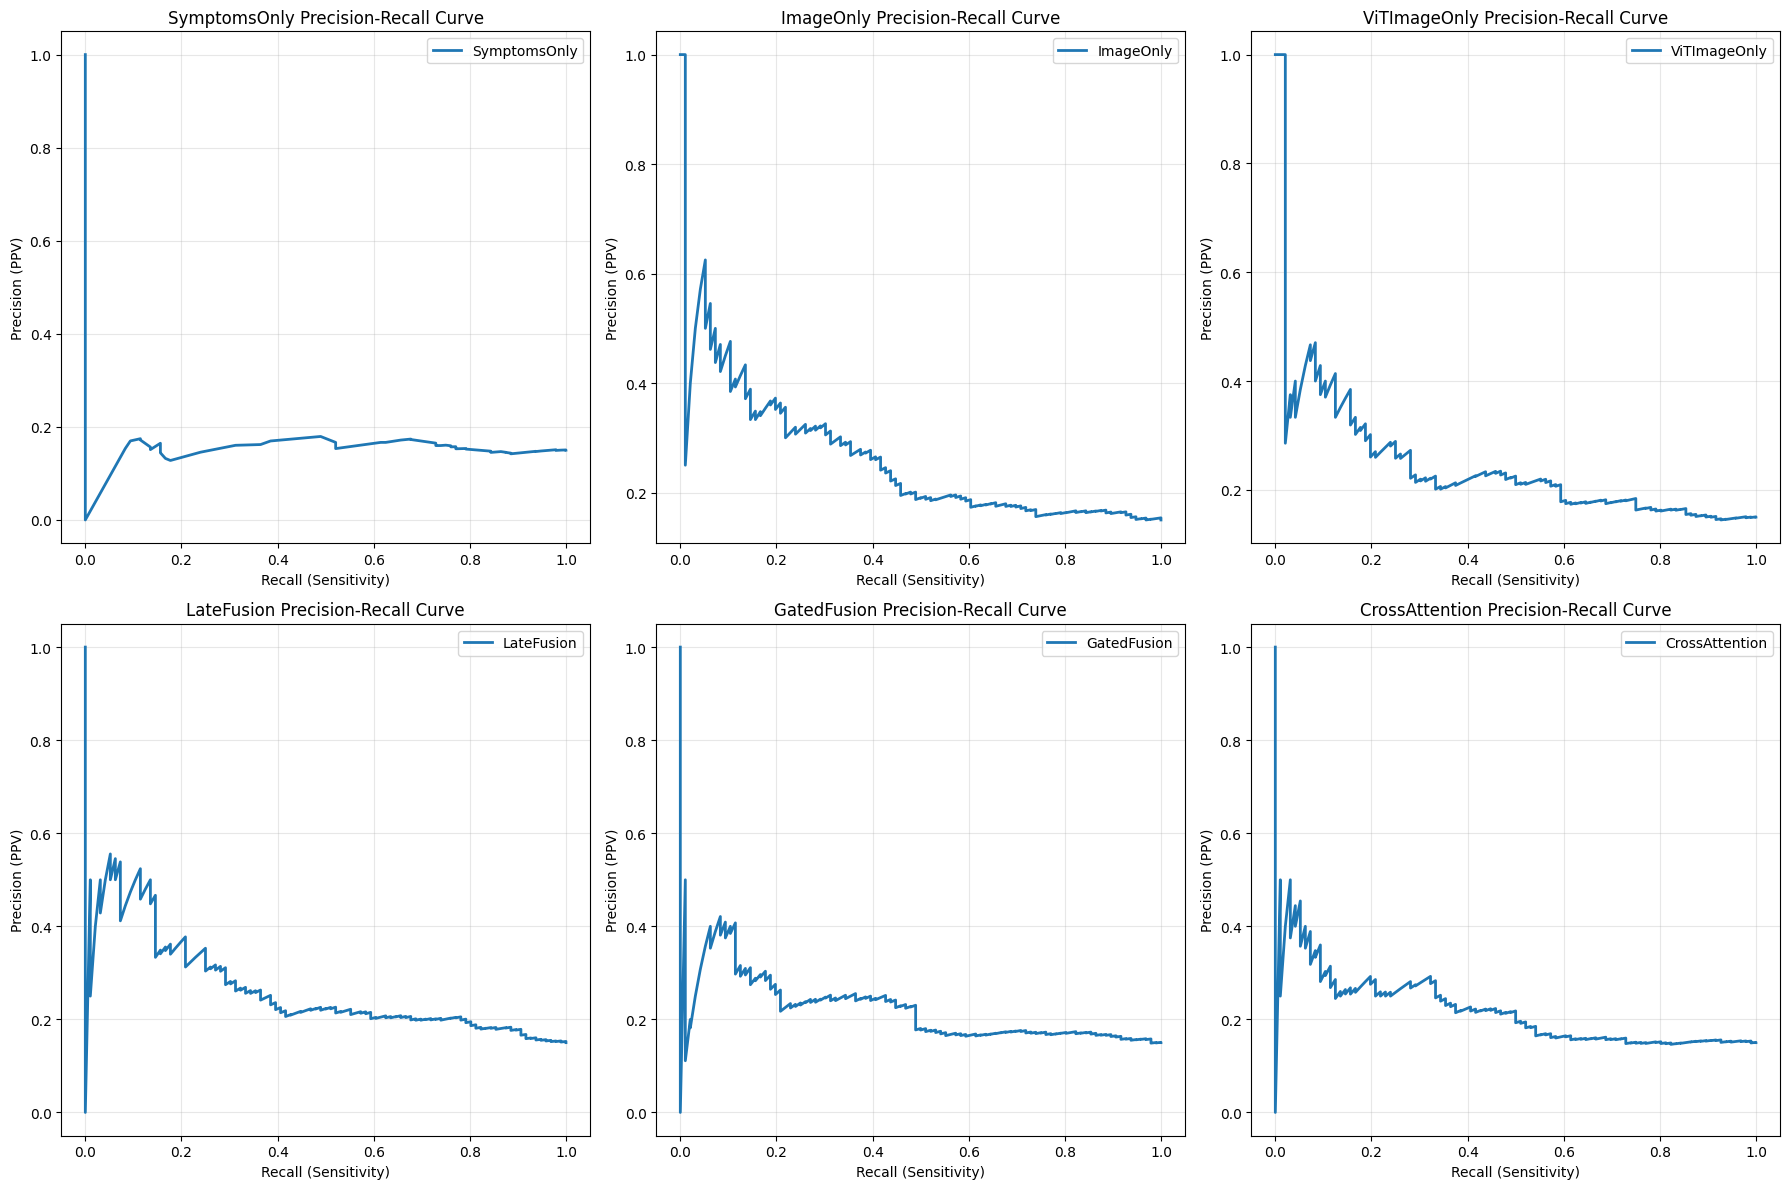

In [38]:
from sklearn.metrics import precision_recall_curve

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    df = pd.read_csv(f"{model_name}_results.csv")
    
    precision, recall, thresholds = precision_recall_curve(df['label'], df['probability'])
    
    axes[idx].plot(recall, precision, linewidth=2, label=model_name)
    axes[idx].set_xlabel('Recall (Sensitivity)')
    axes[idx].set_ylabel('Precision (PPV)')
    axes[idx].set_title(f'{model_name} Precision-Recall Curve')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:

for model_name in model_names:
    df = pd.read_csv(f"{model_name}_results.csv")
    

    high_consensus = (df['consensus'] == 0.0) | (df['consensus'] == 1.0)
    wrong_predictions = df['label'] != df['prediction']
    
    difficult_cases = df[high_consensus & wrong_predictions]
    print(f"\n{model_name}: {len(difficult_cases)} difficult high-consensus cases")






SymptomsOnly: 42 difficult high-consensus cases

ImageOnly: 7 difficult high-consensus cases

ViTImageOnly: 10 difficult high-consensus cases

LateFusion: 10 difficult high-consensus cases

GatedFusion: 7 difficult high-consensus cases

CrossAttention: 13 difficult high-consensus cases
